# Introduction

# Data Preparation

The primary source of data used in this project, was downloaded from the Wharton database in two seperate Csv-files. The first contains data on the stockmarket and the second on various ratios of the companies. These two datasets were merged using Excel before loading it into the Python environment. This was done because they didn't have exactly the same number of rows and consequently the dates didn't match up. By deleting some duplicate lines we got everything lined up correctly.

In [1]:
import pandas as pd
import numpy as np


# Load the csv file of the combined ratios and stocks data and store it as a dataframe.
df = pd.read_csv('df.csv', delimiter=';')

#### Handling NaN values

In [2]:
# adate, public_date and qdate are redundant for our uses after closer inspection therefore we drop those columns.
# curr_ratio and inv_turn simply have to many missing values with whole companies not having any data,
# that keeping the features can't be justified.
# HSICMG has only values for JPM, NKE and CSCO and thus makes no sense to include.
# FACPR and FACSHR have only two rows with a value that is not 0 and seem hardly significant.
# date and permno.1 are duplicate features due to the merging of two data sets and are redundant.
# SICCD was supposed to indicate the industry in which the companies operate, however each company has a unique
# SICCD with some even having more than one. The most this would have achieved therefore is duplicating the permno
# data. We added our own categorization for industry through excel instead.
df = df.drop(columns=['adate', 'public_date', 'qdate', 'curr_ratio', 'inv_turn', 'HSICMG',
                          'FACPR', 'FACSHR', 'SPREAD', 'TICKER', 'date', 'permno.1', 'SICCD'])
    
# dpr is missing for a small number of the first Visa values, we think a backwards fill is therefore adequate
df['dpr'] = df['dpr'].bfill()

# roe is missing for 3 quarters, upon inspection a backwards fill should be adequate
df['roe'] = df['roe'].bfill()

# pe_op_basic and pe_exi are missing for a entry, a backwards fill seems adequate
df['pe_op_basic'] = df['pe_op_basic'].bfill()
df['pe_exi'] = df['pe_exi'].bfill()

# capital ratio is missing for the first few entries of MSF, next entries are 0 so just bfill
df['capital_ratio'] = df['capital_ratio'].bfill()

# All NaN of cash_debt are in Goldman Sachs, fill with median (is very near of the value prior to the NaN's
# and fits into the pattern)
df['cash_debt'].fillna((df['capital_ratio'].mean()), inplace=True)

# lt_ppent no data for Travelers companies found on wharton.
# Only source found on https://www.marketwatch.com/investing/stock/trv/profile but no time series
# therefore just fill 1 so our algorithm won't be too strongly influenced
df['lt_ppent'].fillna(1, inplace=True)

# dltt_be bfill, fits into pattern very nicely
df['dltt_be'] = df['dltt_be'].bfill()

# For ptb there are a small number of values missing, all for the same company. As this ratio fluctuates
# quite a bit, we feel filling with the average of the company is the best option.
df['ptb'].fillna(df.ptb.loc[df['PERMNO'] == 19561].mean(), inplace=True)

# PEG_1yrforward and PEG_ltgforward have a number of missing values with no pattern throughout the data set.
# Filling with the mean of the feature therefore seems adequate
df['PEG_1yrforward'] = df['PEG_1yrforward'].fillna((df['PEG_1yrforward'].mean()))
df['PEG_ltgforward'] = df['PEG_ltgforward'].fillna((df['PEG_ltgforward'].mean()))

# Forward fill for DIVAMT because $-Value per share of distribution has not only a monthly impact but is
# rather a constant indicator, and at the end bfill the first row that was still empty
df['DIVAMT'] = df['DIVAMT'].ffill()
df['DIVAMT'] = df['DIVAMT'].bfill()

# One datapoint was type string, short fix:
df['RETX'] = pd.to_numeric(df['RETX'], errors='coerce')
df['RETX'] = df['RETX'].bfill()

#### Creating Dummy Variables for Categorical Data

In [3]:
# We have a few variables indicating a specific date, like a dividend payout date.
# We convert these to dummy variables to get rid of the massive amount of resulting NaN values.
# First fill all NaN values in the date columns with 0:
df['DCLRDT'] = df['DCLRDT'].fillna(0)
df['PAYDT'] = df['PAYDT'].fillna(0)

# Next step is to fill the existing values in the date columns with a 1, therefore making it a binary variable
# the dates are mostly somewhere in the middle of the month and because we utilize monthly data we just
# indicate if for example a dividend was payed in that month.
for i, row in df.iterrows():
    if row['PAYDT'] != 0:
        df.at[i, 'PAYDT'] = 1
    if row['DCLRDT'] != 0:
        df.at[i, 'DCLRDT'] = 1

df['PAYDT'] = pd.to_numeric(df['PAYDT'], errors='coerce')
df['DCLRDT'] = pd.to_numeric(df['DCLRDT'], errors='coerce')

# So the algorithms can differentiate the different companies, we have to convert
# the PERMNO codes and our industry classification to dummy variables.
df['PERMNO'] = df['PERMNO'].astype(str)
df['Industry'] = df['Industry'].astype(str)
df = pd.get_dummies(df)

#### Deleting rows with too many NaN values

In [4]:
# there are a few rows left with lots of values missing, so we delete all rows with 6 or more values missing  
faulty_rows = []
for row in df.iterrows():
    if row[1].isnull().sum() >= 6:
        faulty_rows.append(df.index[int(row[0])])
df = df.drop(faulty_rows)

#### Creating data matrix and response vector

In [5]:
# create the response vector y (up or down movement)
today = np.log(df['PRC'] / df['PRC'].shift(-1))
direction = np.where(today >= 0, 1, 0)
y = direction

# create the data matrix X
data_final_vars = df.columns.values.tolist()
X = [i for i in data_final_vars if i not in y]
X = df[X]

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


# Logistic Regression

In [6]:
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


logreg = LogisticRegression()

# After lots of experimentation we found the only way to improve our initially rather bad test score was to use
# recursive feature elimination to drop some features. Through experimentation the best result was achieved
# by keeping 41 features.
rfe = RFE(logreg, 41)
rfe = rfe.fit(X, y)

rel_cols = []
for i in range(len(rfe.ranking_)):
    if rfe.ranking_[i] == 1:
        rel_cols.append(df.columns[i])

# Other models however benefit from all the features they can get we therefore do not override our X matrix.
XLR = df[rel_cols]

# Split data in 80% training data and 20% test data
X_train, X_test, y_train, y_test = train_test_split(XLR, y, test_size = 0.2, random_state = 0)

# Fit logit model and print the summary
logit_model = sm.Logit(y,XLR)
result = logit_model.fit()
print(result.summary2())

C:\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


         Current function value: 0.666608
         Iterations: 35
                                  Results: Logit
Model:                     Logit                  No. Iterations:         35.0000  
Dependent Variable:        y                      Pseudo R-squared:       0.029    
Date:                      2018-04-14 16:40       AIC:                    4838.9123
No. Observations:          3568                   BIC:                    5092.2825
Df Model:                  40                     Log-Likelihood:         -2378.5  
Df Residuals:              3527                   LL-Null:                -2449.5  
Converged:                 0.0000                 Scale:                  1.0000   
-----------------------------------------------------------------------------------
                         Coef.    Std.Err.     z    P>|z|     [0.025       0.975]  
-----------------------------------------------------------------------------------
DCLRDT                   13.2244 65363.4037  

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


#### Performance metrics

In [7]:
# Fit logreg model
logreg.fit(X_train, y_train)

# Store the trainscore, testscore and prediction for later use
LR_trainscore = logreg.score(X_train, y_train)
LR_score = logreg.score(X_test, y_test)
LR_pred = logreg.predict(X_test)

# Define Output function used many times throughout this project
# Takes the trainscore, testscore and prediction and prints a summary of the scores and a confusion matrix.
def Output(Xtrain, Xtest, ypred):
    
    # Print performance metrics
    print(15*'-', 'Performance metrics', 15*'-', '\n')
    print('True proportion of Up Movement {:.4f}'.format(y.sum()/y.shape[0]))
    print('Train score: {:.4f}'.format(Xtrain))
    print('Test score: {:.4f}\n'.format(Xtest))

    # Manual confusion matrix as pandas DataFrame
    confm = pd.DataFrame({'Predicted movement': ypred, 'True movement': y_test})
    confm.replace(to_replace={0: 'Down', 1: 'Up'}, inplace=True)
    print(15*'-', 'Confusion Matrix', 15*'-', '\n')
    print(confm.groupby(['True movement', 'Predicted movement']).size().unstack('Predicted movement'))
    
Output(LR_trainscore, LR_score, LR_pred)

--------------- Performance metrics --------------- 

True proportion of Up Movement 0.4425
Train score: 0.5995
Test score: 0.5896

--------------- Confusion Matrix --------------- 

Predicted movement  Down   Up
True movement                
Down                 310   93
Up                   200  111


#### Cross validation

In [8]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score

# Run a 10-fold cross validation to see if results vary strongly for this train-test split
kfold = model_selection.KFold(n_splits=10, random_state=7)

LR_cv = model_selection.cross_val_score(logreg, X_train, y_train, cv=kfold, scoring='accuracy')
print("10-fold cross validation average accuracy: %.4f" % (LR_cv.mean()))

10-fold cross validation average accuracy: 0.5813


#### ROC Curve

In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


# Define ROC_Curve function used many times throughout this project
# Takes a name, y_test, the prediction, and probability and plots an ROC curve. It also saves this plot
# under the specified name.
def ROC_Curve(name, ytest, pred, proba):
    roc_auc = roc_auc_score(ytest, pred)
    fpr, tpr, thresholds = roc_curve(ytest, proba[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label= name + ' (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve: ' + name)
    plt.legend(loc="lower right")
    plt.savefig(name + ' ROC')
    plt.show()

# Store the predicted values for later use
LR_proba = logreg.predict_proba(X_test)

# Plot ROC curve
ROC_Curve('Logistic Regression', y_test, LR_pred, LR_proba)

NameError: name 'logreg' is not defined

# QDA

In [10]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.feature_selection import RFECV


# Redefine the train-test split to use all features in the data-frame
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Run QDA on training data
qda = QDA()
qda = qda.fit(X_train, y_train)
qda

C:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001)

#### Performance metrics

In [11]:
from sklearn import metrics


# Predict classes for qda
QDA_pred = qda.predict(X_test)
posteriors_qda = qda. predict_proba ( X_test )[: , 1]

# Store the trainscore, testscore and prediction for later use
QDA_trainscore = qda.score(X_train, y_train)
QDA_score = qda.score(X_test, y_test)

# Print performance metrics
print ( metrics.classification_report (y_test , QDA_pred ))
Output(QDA_trainscore, QDA_score, QDA_pred)

             precision    recall  f1-score   support

          0       0.57      0.12      0.19       403
          1       0.44      0.88      0.58       311

avg / total       0.51      0.45      0.36       714

--------------- Performance metrics --------------- 

True proportion of Up Movement 0.4425
Train score: 0.4734
Test score: 0.4510

--------------- Confusion Matrix --------------- 

Predicted movement  Down   Up
True movement                
Down                  47  356
Up                    36  275


#### Cross validation

In [12]:
# Redo Cross validation as we redefined the train-test split
QDA_cv = model_selection.cross_val_score(qda, X_train, y_train, cv=kfold, scoring='accuracy')
print("10-fold cross validation average accuracy: %.4f" % (QDA_cv.mean()))

C:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warni

10-fold cross validation average accuracy: 0.4678


C:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


#### ROC Curve

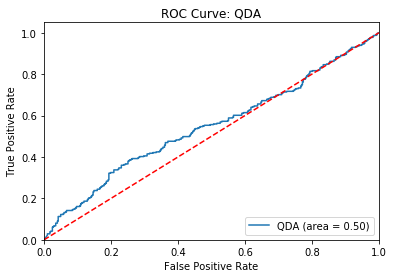

In [13]:
# Plot ROC curve
QDA_proba = qda.predict_proba(X_test)
ROC_Curve('QDA', y_test, QDA_pred, QDA_proba)

# Decision Tree

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler


# Standardize our train data to see if it improves our model fit
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

def grid_search_DT(X_train, X_test, y_train, y_test, y):
    
    # Define settings for each parameter for the grid search
    maxDepth = np.array([5, 6, 8, 9, 10])
    minSamplesNode = np.array([2, 5, 6, 8, 10])
    minSamplesLeaf = np.array([2, 5, 6, 8, 10])
    
    # Define Cross Validation level
    kFold = StratifiedKFold(n_splits=10, random_state=5)

    # Define the parameters to use in grid search
    param_grid = {'criterion': ['gini', 'entropy'],
                  'max_depth': maxDepth,
                  'min_samples_split': minSamplesNode,
                  'min_samples_leaf': minSamplesLeaf}

    # Define the model to be used in grid search
    gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                      param_grid=param_grid,
                      scoring='accuracy',
                      cv=kFold, n_jobs=-1)
    
    gs = gs.fit(X_train, y_train)

    clf = gs.best_estimator_
    clf.fit(X_train, y_train)

    return clf

clf = grid_search_DT(X_train, X_test, y_train, y_test, y)
clf_std = grid_search_DT(X_train_std, X_test_std, y_train, y_test, y)

clf.fit(X_train, y_train)
clf_std.fit(X_train_std, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

#### Performance metrics

In [15]:
# Store the trainscore, testscore and prediction for later use
CLF_trainscore = clf.score(X_train, y_train)
CLF_score = clf.score(X_test, y_test)
CLF_pred = clf.predict(X_test)

# Output the test score to compare with the non-standardized version
print(15*'-', 'Test Score standardized', 15*'-', '\n')
print('Test accuracy: {0: .4f}\n\n'.format(clf_std.score(X_test_std, y_test)))

# Print performance metrics
print(15*'-', 'Test Scores without standarization', 15*'-', '\n')
Output(CLF_trainscore, CLF_score, CLF_pred)

--------------- Test Score standardized --------------- 

Test accuracy:  0.7003


--------------- Test Scores without standarization --------------- 

--------------- Performance metrics --------------- 

True proportion of Up Movement 0.4425
Train score: 0.7642
Test score: 0.7003

--------------- Confusion Matrix --------------- 

Predicted movement  Down   Up
True movement                
Down                 344   59
Up                   155  156


#### ROC Curve

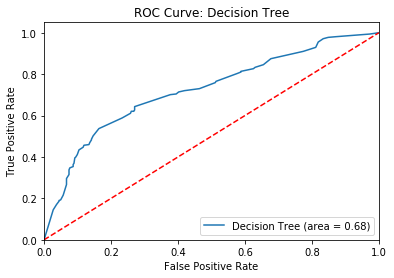

In [16]:
# Plot ROC curve
CLF_proba = clf.predict_proba(X_test)
ROC_Curve('Decision Tree', y_test, CLF_pred, CLF_proba)

#### Create the Decision Tree

In [ ]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
import graphviz
from sklearn.tree import export_graphviz


# Create decision tree plot
dot_data = export_graphviz(clf, filled=True, rounded=True,
                           class_names=['DOWN', 'UP'], feature_names=df.columns.values)

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier


forest = RandomForestClassifier(criterion=clf.criterion, max_depth=clf.max_depth,
                                min_samples_leaf=clf.min_samples_leaf, min_samples_split= clf.min_samples_split,
                                random_state=0, n_jobs=-1)
forest.fit(X_train, y_train)

#### Performance metrics
This is improved greatly later with Grid Search and was left to show the improvement gained.

In [ ]:
print(15*'-', 'Random forest without grid search and no CV', 15*'-', '\n')

# Store the trainscore, testscore and prediction for later use
RF_trainscore = forest.score(X_train, y_train)
RF_score = forest.score(X_test, y_test)
RF_pred = forest.predict(X_test)

# Print performance metrics
Output(RF_trainscore, RF_score, RF_pred)

#### ROC Curve

In [ ]:
# Plot ROC curve
RF_proba = forest.predict_proba(X_test)
ROC_Curve('Random Forest (without Grid Search)', y_test, RF_pred, RF_proba)

#### Applying Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler


def grid_search_RF(X_train, X_test, y_train, y_test, y):    
    
    # Define settings for each parameter for the grid search
    maxDepth = np.array([7, 8, 9])
    minSamplesNode = np.array([2, 3])
    minSamplesLeaf = np.array([9, 10, 11])
    estimators = np.array([10, 11, 12])
    maxFeatures = np.array([5, 20, 'log2', None])
    verbose = np.array([0, 1])
    warmStart = np.array([True, False])
    
    maxDepth = np.array([8])
    minSamplesNode = np.array([2])
    minSamplesLeaf = np.array([10])
    estimators = np.array([11])
    maxFeatures = np.array([20])
    verbose = np.array([0])
    warmStart = np.array([True])

    # Define Cross Validation level
    kFold = StratifiedKFold(n_splits=10, random_state=5)

    # Define the parameters to use in grid search
    param_grid = {'criterion': ['gini', 'entropy'],
                    'max_depth': maxDepth,
                    'min_samples_split': minSamplesNode,
                    'min_samples_leaf': minSamplesLeaf,
                    'n_estimators': estimators,
                    'max_features': maxFeatures,
                    'verbose': verbose,
                    'warm_start': warmStart}

    # Define the model to be used in grid search
    gs = GridSearchCV(estimator=RandomForestClassifier(random_state=0),
                      param_grid=param_grid,
                      scoring='accuracy',
                      cv=kFold, n_jobs=-1)
    
    gs = gs.fit(X_train, y_train)

    rlf = gs.best_estimator_
    rlf.fit(X_train, y_train)

    return rlf

rlf = grid_search_RF(X_train, X_test, y_train, y_test, y)
rlf_std = grid_search_RF(X_train_std, X_test_std, y_train, y_test, y)

rlf.fit(X_train, y_train)
rlf_std.fit(X_train_std, y_train)

#### Performance metrics

In [ ]:
# Store the trainscore, testscore and prediction for later use
RF_trainscore_grid = rlf.score(X_train, y_train)
RF_score_grid = rlf.score(X_test, y_test)
RF_pred_grid = rlf.predict(X_test)

# Print performance metrics
Output(RF_trainscore_grid, RF_score_grid, RF_pred_grid)

#### ROC Curve

In [ ]:
# Plot ROC curve
RF_proba_grid = rlf.predict_proba(X_test)
ROC_Curve('Random Forest', y_test, RF_pred_grid, RF_proba_grid)

# SVM

## SVM linear
Creating a svm linear object, this object presents a linear SVM with C = 0.

In [ ]:
from sklearn.svm import SVC 


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

svm_linear = SVC(kernel='linear', C=1)
svm_linear

Now we apply the linear svm object to our data and create a confusion matrix.

In [ ]:
svm_linear.fit(X_train_std, y_train)

SVM_trainscore_linear = svm_linear.score(X_train_std, y_train)
SVM_score_linear = svm_linear.score(X_test_std, y_test)
SVM_pred_linear = svm_linear.predict(X_test_std)

Output(SVM_trainscore_linear, SVM_score_linear, SVM_pred_linear)

## SVM poly

We wanted to know if there will be some significant differences using the three non-linear Kernel functions, as you can see below.

Creation of a svm poly object with random state of 1.

In [ ]:
svm_poly = SVC(kernel='poly', random_state=1)
svm_poly

Now we apply the poly svm object to our data and create a confusion matrix.


In [ ]:
svm_poly.fit(X_train_std, y_train)

SVM_trainscore_poly = svm_poly.score(X_train_std, y_train)
SVM_score_poly = svm_poly.score(X_test_std, y_test)
SVM_pred_poly = svm_poly.predict(X_test_std)

Output(SVM_trainscore_poly, SVM_score_poly, SVM_pred_poly)

## SVM sigmoid

Here we create a svm object with non-linar Kernel function sigmoid with random state of 1.

In [ ]:
svm_sigmoid = SVC(kernel='sigmoid', random_state=1)
svm_sigmoid

Here again, we apply the svm sigmoid object to our data and create as well a confusion matrix. 

In [ ]:
svm_sigmoid.fit(X_train_std, y_train)

SVM_trainscore_sigmoid = svm_sigmoid.score(X_train_std, y_train)
SVM_score_sigmoid = svm_sigmoid.score(X_test_std, y_test)
SVM_pred_sigmoid = svm_sigmoid.predict(X_test_std)

Output(SVM_trainscore_sigmoid, SVM_score_sigmoid, SVM_pred_sigmoid)

## SVM rbf

Last but not least the implementation of a svm object with the Kernel function rbf.

In [ ]:
svm_rbf = SVC(kernel='rbf', random_state=1)
svm_rbf

As last time, we apply the new created svm to our data and create a confusion matrix.

In [ ]:
svm_rbf.fit(X_train_std, y_train)

SVM_trainscore_rbf = svm_rbf.score(X_train_std, y_train)
SVM_score_rbf = svm_rbf.score(X_test_std, y_test)
SVM_pred_rbf = svm_rbf.predict(X_test_std)

Output(SVM_trainscore_rbf, SVM_score_rbf, SVM_pred_rbf)

As you can see through the results, the linear svm object gives us the best result, compared with the non-linear Kernel functions.

## SVM poly, balanced
Because of possible class imbalance, we add the class weight element in our svm creation function and insert the value "balanced“. We apply this to all non-linear Kernel functions.

Creation of a svm poly object with class weight = balanced.

In [ ]:
svm_poly = SVC(kernel='poly', random_state=1, class_weight='balanced')
svm_poly.fit(X_train_std, y_train)

y_pred = svm_poly.predict(X_test_std)
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))
print("Test score: {:.2f}".format(svm_poly.score(X_test_std, y_test)))

As you can see, our Test Score decreases from 56.68% to 53%.

## SVM sigmoid, balanced
Creation of a svm sigmoid object with class weight = balanced.

In [ ]:
svm_sigmoid = SVC(kernel='sigmoid', random_state=1, class_weight='balanced')
svm_sigmoid.fit(X_train_std, y_train)

y_pred = svm_sigmoid.predict(X_test_std)
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))
print("Test score: {:.2f}".format(svm_sigmoid.score(X_test_std, y_test)))

Here as well, the Test Score deacreases from 55.18% to 54%. Because of  deacreasing Test Scores, we stopped testing the last non-linear Kernel function.

## SVM applying Pipelines

We import pipline through sklearn and use grid search to discover the best combination of values for C and polynomial degrees.

In [ ]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([('scaler', StandardScaler()),('svm_poly', SVC(kernel='poly', random_state=0))])

In [ ]:
param_grid = {'svm_poly__C': [0.1, 1, 10, 100], 'svm_poly__degree': [1, 2, 3, 4, 5]}

In [ ]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs= -1)
grid.fit(X_train_std, y_train)

PGS_score = grid.score(X_test_std, y_test)
PGS_params = grid.best_params_

print('Best CV accuracy: {: .4f}'.format(grid.best_score_))
print('Test score: {: .4f}'.format(PGS_score))
print('Best parameters: {}'.format(PGS_params))

As you can see the best value for C is 10 and not very suprising, the best polynomial degree is one, which means nothing else than a linear function. As you can see above, the best result, comparing all the four Kernel functions, we had with the linear svm.

# Feature Importance
Now we would like to know, which feature of our dataset explains our model in the best way. We extreact the feature labels and create a Random Forest object, fit the data and extract the feature importance attributes.

In [ ]:
feat_labels = df.columns [:]
forest = RandomForestClassifier(random_state =1)
forest.fit( X_train_std , y_train )
importances = forest.feature_importances_

We sort our output by relative importance and print the top features.

In [ ]:
indices = np.argsort(importances)[::-1]
n = 20
print(df.shape)
for i in range (n):
    print('{0:2d}) {1:7s} {2:6.4f}'.format (i + 1, feat_labels[indices[i]], importances[indices[i]]))

# Get cumsum of the n most important features
feat_imp = np.sort(importances)[::-1]
sum_feat_imp = np.cumsum( feat_imp )[:n]

To have a better overview we plot the results above

In [ ]:
# Plot Feature Importance ( both cumul ., individual )
plt.figure(figsize = (12, 8))
plt.bar(range(n), importances[indices[:n]], align = 'center')
plt.xticks(range(n), feat_labels[indices[:n]], rotation = 90)
plt.xlim([-1, n])
plt.xlabel('Feature')
plt.ylabel('Rel. Feature Importance')
plt.step(range(n), sum_feat_imp, where = 'mid', label = 'Cumulative importance')
plt.tight_layout();

It is nice to see, that ten of the best features were added additionally, so we did a good selection.

# Principal Component Analysis


In [ ]:
from sklearn.feature_selection import SelectFromModel

pipe = Pipeline([('feature_selection', SelectFromModel(RandomForestClassifier(), threshold='median')),('scaler', StandardScaler()),('classification', SVC())])
pipe.fit(X_train_std, y_train).score(X_test_std, y_test)

In [ ]:
from sklearn.decomposition import PCA

q = 10

pca = PCA(n_components=q)
pca.fit(X_train_std)
pca

pca = PCA().fit(X_train_std)

q = X_train_std.shape[1]

expl_var = pca.explained_variance_ratio_
sum_expl_var = np.cumsum(expl_var)[:q]

In [ ]:
plt.figure(figsize=(12,6))
plt.bar(range(1, q+1), expl_var, align='center')
plt.xticks(range(1, q+1, 5))
plt.xlim([0, q+1])
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.step(range(1, 1+q), sum_expl_var, where='mid')
plt.tight_layout();

# Results
As a little summary, we list all our resutls from the different models and see, that the best approximation we get by using decsion trees.

In [ ]:
print(15*'-', 'Test Score Logistic Regression', 15*'-', '\n')
print('Test accuracy: {:.4f}\n'.format(LR_score))

print(15*'-', 'Test Score QDA', 15*'-', '\n')
print('Test accuracy: {:.4f}\n'.format(QDA_score))

print(15*'-', 'Test Score Decision Tree', 15*'-', '\n')
print('Test accuracy: {:.4f}\n'.format(CLF_score))

print(15*'-', 'Test Score Random Forest', 15*'-', '\n')
print('Test accuracy: {:.4f}\n'.format(RF_score_grid))

print(15*'-', 'Test Score SVM linear', 15*'-', '\n')
print('Test accuracy: {:.4f}\n'.format(SVM_score_linear))

print(15*'-', 'Test Score SVM poly', 15*'-', '\n')
print('Test accuracy: {:.4f}\n'.format(SVM_score_poly))

print(15*'-', 'Test Score SVM sigmoid', 15*'-', '\n')
print('Test accuracy: {:.4f}\n'.format(SVM_score_sigmoid))

print(15*'-', 'Test Score SVM rbf', 15*'-', '\n')
print('Test accuracy: {:.4f}\n'.format(SVM_score_rbf))

print(15*'-', 'Test Score poly with grid search', 15*'-', '\n')
print('Best parameters: {}'.format(PGS_params))
print('Test accuracy: {:.4f}'.format(PGS_score))